In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import numpy as np 
import pandas as pd
from src import losses
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import copy
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
from torch.distributions import MultivariateNormal as MVN
from torch.utils.data import Dataset
import scipy.stats as st
from sklearn.mixture import GaussianMixture

device = "cuda" if torch.cuda.is_available() else "cpu"

## 1D 

In [3]:
pred   = torch.rand(512, 1, 16, 16)
target = torch.rand(512, 1, 16, 16)

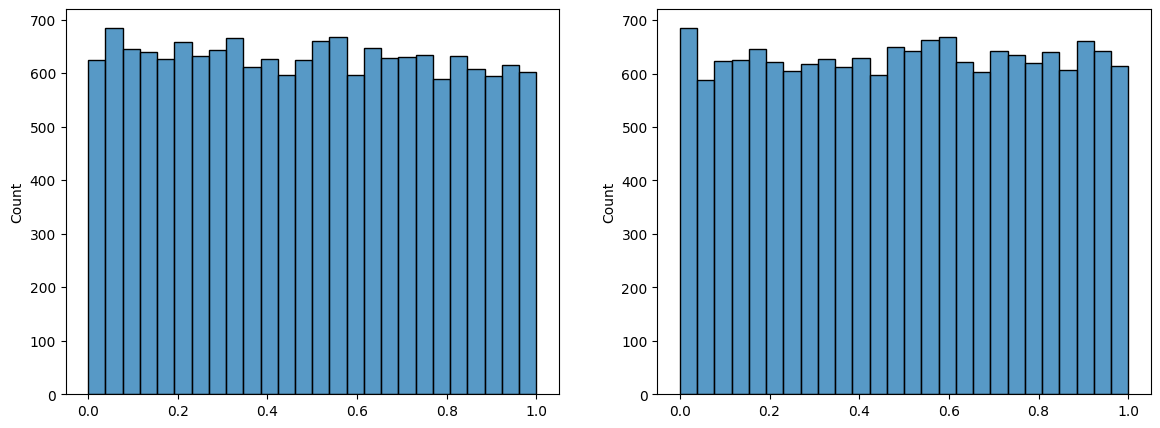

In [32]:
fig, axs = plt.subplots(1, 2, figsize = (14, 5))

pred_ravel = torch.flatten(pred)
target_raval = torch.flatten(target)
sns.histplot(pred_ravel, ax = axs[0])
sns.histplot(target_raval, ax = axs[1])
None

In [9]:
loss = losses.weighted_mse_loss(pred.to(device), target.to(device), weights=None)
loss

tensor(0.1648)

In [5]:
bmc = losses.BMCLoss(init_noise_sigma = 1.0)
loss = bmc(pred.to(device), target.to(device))
loss

tensor(12.4842, device='cuda:0', grad_fn=<DivBackward0>)

In [4]:
bmc = losses.BMCLoss(init_noise_sigma = 1.0)
loss = bmc(pred.to(device), target.to(device))
loss

tensor(12.4842)

## Test

### Losses

In [2]:
class ReweightL2(_Loss):
    def __init__(self, train_dist, reweight='inverse'):
        super(ReweightL2, self).__init__()
        self.reweight = reweight
        self.train_dist = train_dist

    def forward(self, pred, target):
        reweight = self.reweight
        prob = self.train_dist.log_prob(target).exp().squeeze(-1)
        if reweight == 'inverse':
            inv_prob = prob.pow(-1)
        elif reweight == 'sqrt_inv':
            inv_prob = prob.pow(-0.5)
        else:
            raise NotImplementedError
        inv_prob = inv_prob / inv_prob.sum()
        loss = F.mse_loss(pred, target, reduction='none').sum(-1) * inv_prob
        loss = loss.sum()
        return loss


class GAILossMD(_Loss):
    """
    Multi-Dimension version GAI, compatible with 1-D GAI
    """

    def __init__(self, init_noise_sigma, gmm):
        super(GAILossMD, self).__init__()
        self.gmm = gmm
        self.gmm = {k: torch.tensor(self.gmm[k]) for k in self.gmm}
        self.noise_sigma = torch.nn.Parameter(torch.tensor(init_noise_sigma))

    def forward(self, pred, target):
        noise_var = self.noise_sigma ** 2
        loss = gai_loss_md(pred, target, self.gmm, noise_var)
        return loss


def gai_loss_md(pred, target, gmm, noise_var):
    I = torch.eye(pred.shape[-1])
    mse_term = -MVN(pred, noise_var*I).log_prob(target)
    balancing_term = MVN(gmm['means'], gmm['variances']+noise_var*I).log_prob(pred.unsqueeze(1)) + gmm['weights'].log()
    balancing_term = torch.logsumexp(balancing_term, dim=1)
    loss = mse_term + balancing_term
    loss = loss * (2 * noise_var).detach()
    return loss.mean()


class BMCLossMD(_Loss):
    """
    Multi-Dimension version BMC, compatible with 1-D BMC
    """

    def __init__(self, init_noise_sigma):
        super(BMCLossMD, self).__init__()
        self.noise_sigma = torch.nn.Parameter(torch.tensor(init_noise_sigma))

    def forward(self, pred, target):
        noise_var = self.noise_sigma ** 2
        loss = bmc_loss_md(pred, target, noise_var)
        return loss


def bmc_loss_md(pred, target, noise_var):
    I = torch.eye(pred.shape[-1])
    logits = MVN(pred.unsqueeze(1), noise_var*I).log_prob(target.unsqueeze(0))
    loss = F.cross_entropy(logits, torch.arange(pred.shape[0]))
    loss = loss * (2 * noise_var).detach()
    return loss

### Constants 

In [3]:

# =========== CONSTANTS ==============
# Training
NUM_EPOCHS = 10000
PRINT_FREQ = NUM_EPOCHS // 10
BATCH_SIZE = 256
NUM_TRAIN_ITERS = 4
NUM_VAL_ITERS = 1
NUM_TRAIN_SAMPLES = BATCH_SIZE * NUM_TRAIN_ITERS
NUM_VAL_SAMPLES = BATCH_SIZE * NUM_VAL_ITERS
NUM_TEST_SAMPLES = BATCH_SIZE * NUM_VAL_ITERS

# Dimensions
X_DIM = 2
Y_DIM = 2

# Data Range
Y_UB = torch.ones(Y_DIM) * 5
Y_LB = torch.ones(Y_DIM) * -5

# Linear Relation and Noise Scale
NOISE_SIGMA = 1.
NOISE_COVARIANCE = torch.eye(Y_DIM) * (NOISE_SIGMA ** 2)
ORACLE_MATRIX = torch.randn([X_DIM, Y_DIM]) * 0.01

# Normal Distribution Parameters
Y_COVARIANCE = torch.eye(Y_DIM)
Y_COVARIANCE = Y_COVARIANCE * 0.5 + torch.ones_like(Y_COVARIANCE) * 0.5
Y_MEAN = (Y_LB + Y_UB) / 2
# Specify which training distribution to use
TRAIN_DIST = 'normal'

# predefine distributions
DIST_DICT = {
    'uniform': torch.distributions.Uniform(Y_LB, Y_UB),
    'normal': torch.distributions.MultivariateNormal(loc=Y_MEAN, covariance_matrix=Y_COVARIANCE)
}

CRITERIA_TO_USE = [
    'MSE',
    'Reweight',
    'GAI',
    'BMC',
    'GAI Learnable Noise',
    'BMC Learnable Noise'
]
# ======= END OF CONSTANTS ==========

### Initials

In [4]:
def f(x):
    # This function will never be called, so we leave the inverse here
    y = ORACLE_MATRIX.inverse() @ x.unsqueeze(-1)
    return y.squeeze()


def f_inv(y):
    x = ORACLE_MATRIX @ y.unsqueeze(-1)
    return x.squeeze()

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {avg' + self.fmt + '}'
        return fmtstr.format(**self.__dict__)


class DummyDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __getitem__(self, index):
        return self.inputs[index], self.targets[index]

    def __len__(self):
        return len(self.inputs)


def get_gmm(dist, n_components):
    # fit a **ground truth** label distribution
    all_labels = dist.sample([10000, ])     # assume sufficient samples
    if len(all_labels.shape) == 1:
        all_labels = all_labels.unsqueeze(-1)
    gmm = GaussianMixture(n_components=n_components).fit(all_labels)
    gmm_dict = {'means': gmm.means_, 'weights': gmm.weights_, 'variances': gmm.covariances_}
    return gmm_dict


def make_dataframe(x, y, method=None):
    x = list(x[:, 0].detach().numpy())
    y = list(y[:, 0].detach().numpy())
    if method is not None:
        method = [method for _ in range(len(x))]
        df = pd.DataFrame({'x': x, 'y': y, 'Method': method})
    else:
        df = pd.DataFrame({'x': x, 'y': y})
    return df


def unzip_dataloader(training_loader):
    all_x = []
    all_y = []
    for data, label in training_loader:
        all_x.append(data)
        all_y.append(label)
    all_x = torch.cat(all_x)
    all_y = torch.cat(all_y)
    return all_x, all_y


def visualize(model_dict, train_loader, test_loader, Y_LB, Y_UB, K, B):
    sns.set_theme(palette='colorblind')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Get model outputs
    model_df = []
    x_test, _ = unzip_dataloader(test_loader)
    for model_name in model_dict:
        model = model_dict[model_name]
        model.eval()
        y = model(x_test)
        model_df.append(make_dataframe(x_test, y, model_name))

    training_df = make_dataframe(*unzip_dataloader(train_loader), 'Training')
    test_df = make_dataframe(*unzip_dataloader(test_loader), 'Testing')
    oracle_df = make_dataframe(*unzip_dataloader(test_loader), 'Oracle')

    # plot oracle and predictions
    sns.lineplot(data=pd.concat([oracle_df, *model_df], ignore_index=True), x='x', y='y', hue='Method', ax=ax1)

    # plot data points
    sns.scatterplot(data=training_df, x='x', y='y', color='#003ea1', alpha=0.2, linewidths=0, s=100, ax=ax1,
                    legend=False)

    ax1.set_xlim((Y_LB - B) / K, (Y_UB - B) / K)
    ax1.set_ylim(Y_LB, Y_UB)
    ax1.set_xlabel(r'$x$', fontsize=10)
    ax1.set_ylabel(r'$y$', fontsize=10)

    # plot training histogram
    bins = np.linspace(Y_LB, Y_UB, 20)
    sns.histplot(data=training_df, y='y', kde=False, stat='density', hue='Method', common_norm=False, bins=bins, ax=ax2)

    # plot kdeplot
    sns.kdeplot(data=pd.concat([training_df, *model_df, test_df], ignore_index=True), y='y', hue='Method',
                common_norm=False, ax=ax2)

    ax2.set_ylim(Y_LB, Y_UB)
    ax2.set_xlabel(r'$p(y)$', fontsize=10)
    ax2.set_ylabel(r'$y$', fontsize=10)
    plt.tight_layout()
    plt.show()


def hist_3d(ax, data, title, Y_LB, Y_UB, zmax=0.06):
    xx, yy = np.mgrid[Y_LB[0].item():Y_UB[0].item():100j, Y_LB[1].item():Y_UB[1].item():100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = data.transpose(0, 1).detach().cpu().numpy()
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel('y1')
    ax.set_ylabel('y2')
    ax.set_zlabel('p(y)')
    ax.set_zlim(0, zmax)
    ax.set_title(title)
    surf.set_clim(vmin=0, vmax=zmax)
    ax.view_init(55, 25)


def visualize_md(model_dict, train_loader, test_loader, Y_LB, Y_UB):
    num_models = len(list(model_dict.keys()))
    fig = plt.figure(figsize=((num_models + 2) * 4, 5))
    subplot_idx = 1

    # train distribution
    ax = fig.add_subplot(1, num_models + 2, subplot_idx, projection='3d')
    subplot_idx += 1
    hist_3d(ax, unzip_dataloader(train_loader)[1], 'Train', Y_LB, Y_UB, zmax=0.14)

    # test distribution
    ax = fig.add_subplot(1, num_models + 2, subplot_idx, projection='3d')
    subplot_idx += 1
    hist_3d(ax, unzip_dataloader(test_loader)[1], 'Test', Y_LB, Y_UB)

    for model_name in model_dict:
        model = model_dict[model_name]
        model.eval()
        x_test, _ = unzip_dataloader(test_loader)
        pred = model(x_test)
        ax = fig.add_subplot(1, num_models + 2, subplot_idx, projection='3d')
        subplot_idx += 1
        hist_3d(ax, pred, model_name, Y_LB, Y_UB)

    plt.tight_layout()
    plt.show()

### Linear model 

In [5]:
# Define a linear regressor
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, output_dim),
        )

    def forward(self, x):
        x = self.mlp(x)
        return x

In [20]:

def prepare_data():
    # Training label samples
    y_train = DIST_DICT[TRAIN_DIST].sample((NUM_TRAIN_SAMPLES,))
    assert len(y_train) == NUM_TRAIN_SAMPLES

    # Assume a gaussian noise has been added to observed y
    noise_distribution = torch.distributions.MultivariateNormal(torch.zeros(Y_DIM), covariance_matrix=NOISE_COVARIANCE)
    noise = noise_distribution.sample((NUM_TRAIN_SAMPLES,))

    # then the oracle y should be
    y_train_oracle = y_train - noise

    x_train = f_inv(y_train_oracle)

    # Evaluate on balanced (uniform) y distribution
    y_eval = DIST_DICT['uniform'].sample((NUM_VAL_SAMPLES,))
    x_eval = f_inv(y_eval)

    # Test set
    y_test = DIST_DICT['uniform'].sample((NUM_TEST_SAMPLES,))
    x_test = f_inv(y_test)

    train_loader = DataLoader(DummyDataset(x_train, y_train), BATCH_SIZE, shuffle=True)
    eval_loader = DataLoader(DummyDataset(x_eval, y_eval), BATCH_SIZE)
    test_loader = DataLoader(DummyDataset(x_test, y_test), BATCH_SIZE)

    return train_loader, eval_loader, test_loader


def prepare_model():
    model = LinearModel(input_dim=X_DIM, output_dim=Y_DIM)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    return model, optimizer, scheduler

In [ ]:
def train(train_loader, eval_loader, test_loader, model, optimizer, scheduler, criterion):
    best_eval_loss = 1e8
    model_best = None
    for epoch in range(NUM_EPOCHS):
        train_loss = AverageMeter('train loss')
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            train_loss.update(loss.item())
            loss.backward()
            optimizer.step()
        scheduler.step()

        if (epoch + 1) % PRINT_FREQ == 0:
            print('epoch: ', epoch + 1)
            model.eval()
            eval_loss = AverageMeter('eval loss')
            for data, target in eval_loader:
                pred = model(data)
                loss = F.mse_loss(pred, target)
                eval_loss.update(loss.item())

            print(train_loss)
            print(eval_loss)
            print('-' * 10)
            if best_eval_loss > eval_loss.avg:
                model_best = copy.deepcopy(model)
                best_eval_loss = eval_loss.avg

    print('best eval loss {:.6f}'.format(best_eval_loss))
    model_best.eval()
    test_loss = AverageMeter('test loss')
    for data, target in test_loader:
        pred = model(data)
        loss = F.mse_loss(pred, target)
        test_loss.update(loss.item())
    print(test_loss)
    print('=' * 20)
    return model_best, test_loss.avg


def train_model(train_loader, eval_loader, test_loader):
    gmm = get_gmm(dist=DIST_DICT[TRAIN_DIST], n_components=1)
    criteria = {
        'MSE': nn.MSELoss(),
        'Reweight': ReweightL2(DIST_DICT[TRAIN_DIST]),
        'GAI': GAILossMD(init_noise_sigma=NOISE_SIGMA, gmm=gmm),
        'BMC': BMCLossMD(init_noise_sigma=NOISE_SIGMA),
        # For learnable noise, we assume we don't know the ground truth noise scale
        # Therefore we multiply an offset 1.5 to the ground truth noise scale
        'GAI Learnable Noise': GAILossMD(init_noise_sigma=1.5 * NOISE_SIGMA, gmm=gmm),
        'BMC Learnable Noise': BMCLossMD(init_noise_sigma=1.5 * NOISE_SIGMA),
    }
    criteria = {k: criteria[k] for k in CRITERIA_TO_USE}  # Only use selected criteria
    perf_stats = {}
    models_trained = {}

    for criterion_name, criterion in criteria.items():
        print("Training with distribution {} and criterion {}".format(TRAIN_DIST, criterion_name))
        model, optimizer, scheduler = prepare_model()
        if 'Learnable Noise' in criterion_name:
            optimizer.add_param_group({'params': criterion.parameters(), 'lr': 0.01})
        model_best, perf_stats[criterion_name] = \
            train(train_loader, eval_loader, test_loader, model, optimizer, scheduler, criterion)
        models_trained[criterion_name] = model_best

    print('Final results')
    for method in perf_stats:
        print('{0: <20}: {1:.6f}'.format(method, perf_stats[method]))
    return models_trained


def main():
    train_loader, eval_loader, test_loader = prepare_data()
    models_trained = train_model(train_loader, eval_loader, test_loader)
    visualize_md(models_trained, train_loader, test_loader, Y_LB, Y_UB)


if __name__ == '__main__':
    main()